In [ ]:
import json
import re
import pandas as pd
import urllib
from urllib.request import Request
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import requests
!pip install geopandas
import geopandas
import zipfile, re, os

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 6.3 MB 34.4 MB/s 
     |████████████████████████████████| 16.7 MB 37.2 MB/s 


In [ ]:
url = 'https://www.otodom.pl/pl/oferty/sprzedaz/mieszkanie/krakow?page='
pages = []

for page_number in range(1, 100):
    if page_number % 10 == 0:
        print(f'Pobieranie strony {page_number}')

    try:
        with urllib.request.urlopen(f'{url}{page_number}') as resp:
            processed_page = BeautifulSoup(resp.read().decode('utf-8'), 'html.parser')
            pages.append(processed_page)
    except:
        continue

Pobieranie strony 10
Pobieranie strony 20
Pobieranie strony 30
Pobieranie strony 40
Pobieranie strony 50
Pobieranie strony 60
Pobieranie strony 70
Pobieranie strony 80
Pobieranie strony 90


In [ ]:
offer_previews = []

for page in pages:
    offer_previews += page.find_all('a', {'data-cy': 'listing-item-link'}) 

# print(offer_previews[0].prettify())

In [ ]:
offer_prefix = 'https://www.otodom.pl'
offers = []

for offer in offer_previews:
    offer_suffix = offer['href']

    try:
        with urllib.request.urlopen(f'{offer_prefix}{offer_suffix}') as resp:
            processed_offer = BeautifulSoup(resp.read().decode('utf-8'), 'html.parser')
            offers.append(processed_offer)
    except:
        continue

# print(offers[0].prettify())

In [ ]:
houses_data = []

for offer_html in offers:
    house = {}
    
    try:
        house['title'] = offer_html.find('h1').text
    except:
        house['title'] = 'None'
    
    try:
        house['price'] = int(offer_html.find('strong', {'aria-label': 'Cena'}).text.replace(' zł', '').replace(' ', ''))
    except:
        house['price'] = -1
            
    try:
        house['pricePerMeter'] = int(offer_html.find('div', {'aria-label': 'Cena za metr kwadratowy'}).text.replace(' ', '').replace('zł/m²', '').replace('zł/м²', ''))
    except:
        house['pricePerMeter'] = -1

    try:
        house['address'] = offer_html.find('a', {'aria-label': 'Adres'}).text
    except:
        house['address'] = 'None'
        
    try:
        distrcit = house['address'].split(',')[1].strip()
        
        if distrcit.upper() != "MAŁOPOLSKIE":
            house['district'] = distrcit.upper()
        else:
            house['district'] = 'none'

    except:
        house['district'] = 'None'

    try:
        house['surface'] = float(offer_html.find('div', {'aria-label': 'Powierzchnia'}).select('div.estckra5')[0].text.replace(',', '.').replace(' m²', ''))
    except:
        house['surface'] = -1

    try:
        house['rooms'] = int(offer_html.find('div', {'aria-label': 'Liczba pokoi'}).select('div.estckra5')[0].text)
    except:
        house['rooms'] = -1

    try:
        house['floor'] = offer_html.find('div', {'aria-label': 'Piętro'}).select('div.estckra5')[0].text
    except:
        house['floor'] = 'None'
        
    try:
        house['rent'] = float(offer_html.find('div', {'aria-label': 'Czynsz'}).select('div.estckra5')[0].text.replace(',', '.').replace(' zł', ''))
    except:
        house['rent'] = -1
                    
    try:
        house['ownership'] = offer_html.find('div', {'aria-label': 'Forma własności'}).select('div.estckra5')[0].text
    except:
        house['ownership'] = 'none'
                        
    try:
        house['condition'] = offer_html.find('div', {'aria-label': 'Stan wykończenia'}).select('div.estckra5')[0].text
    except:
        house['condition'] = 'none'
                            
    try:
        house['balcony'] = offer_html.find('div', {'aria-label': 'Balkon / ogród / taras'}).select('div.estckra5')[0].text
    except:
        house['balcony'] = 'none'
                       
    try:
        house['praking'] = offer_html.find('div', {'aria-label': 'Miejsce parkingowe'}).select('div.estckra5')[0].text
    except:
        house['praking'] = 'none'
                         
    try:
        house['heating'] = offer_html.find('div', {'aria-label': 'Ogrzewanie'}).select('div.estckra5')[0].text
    except:
        house['heating'] = 'none'

    try:
        house['year'] = int(offer_html.find('div', {'aria-label': 'Rok budowy'}).select('div.estckra5')[0].text)
    except:
        house['year'] = -1

    house['url'] = offer_html.find('link', {'rel': 'alternate'})['href']

    """
    try:
        house['img'] = offer_html.find('img', {'class': 'image-gallery-image'})['src']
    except:
        continue
    """

    houses_data.append(house)

In [ ]:
df = pd.DataFrame.from_dict(houses_data)
df = df[df.price > 0]
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
df.head()

,title,price,pricePerMeter,address,district,surface,rooms,floor,rent,ownership,condition,balcony,praking,heating,year,url
0,"PROMO! Kameralne mieszkanie 64m2, ul. WIDNA, O...",714000,11156,"Kraków, Prądnik Czerwony, Rakowice, ul. Widna",PRĄDNIK CZERWONY,64.00,3,2/3,600.00,pełna własność,do zamieszkania,"balkon, ogródek",none,gazowe,1930,https://www.otodom.pl/pl/oferta/promo-kameraln...
1,"Sprzedam 2-pok. mieszkanie, cena do negocjacji",495000,12541,"Kraków, Podgórze Duchackie, Wola Duchacka, ul....",PODGÓRZE DUCHACKIE,39.47,2,1/4,250.00,pełna własność,do wykończenia,balkon,none,miejskie,2020,https://www.otodom.pl/pl/oferta/sprzedam-2-pok...
2,Sprzedam mieszkanie 2 pokojowe nowe wykonczone,447000,12081,"Kraków, Bieżanów-Prokocim",BIEŻANÓW-PROKOCIM,37.00,2,2/2,280.00,pełna własność,do zamieszkania,balkon,garaż/miejsce parkingowe,miejskie,2021,https://www.otodom.pl/pl/oferta/sprzedam-miesz...
3,53m2 Starowiślna Po Remoncie Gotowe do zamiesz...,749000,14132,"Kraków, Stare Miasto, ul. Starowiślna",STARE MIASTO,53.00,2,3/4,360.00,pełna własność,do zamieszkania,none,none,elektryczne,1926,https://www.otodom.pl/pl/oferta/53m2-starowisl...
4,Piękne 3 pokojowe mieszkanie przy ulicy Miodowej!,790000,15800,"Kraków, Śródmieście, Miodowa",ŚRÓDMIEŚCIE,50.00,2,4/4,-1.00,pełna własność,do zamieszkania,none,none,none,1922,https://www.otodom.pl/pl/oferta/piekne-3-pokoj...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03915cf550>]],
      dtype=object)

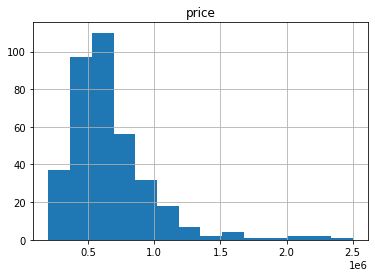

In [ ]:
df.hist(column='price', bins=14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f03914c7b50>]],
      dtype=object)

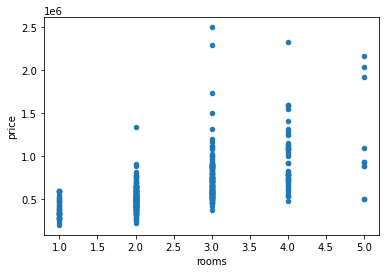

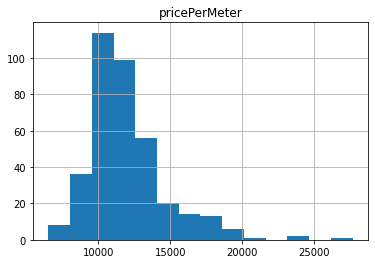

In [ ]:
df.plot.scatter(x='rooms', y='price')
df.hist(column='pricePerMeter', bins=14)

In [ ]:
def read_shape_from_zip(zip_filename, entry_name_regex):
    z = zipfile.ZipFile(zip_filename, mode="r")
    dbf_name = list(filter(
            lambda x: re.match(entry_name_regex + r'.*\.dbf$', os.path.basename(x)), 
            z.namelist()
    ))[0]
    z.close()
    return geopandas.read_file(dbf_name, encoding='utf-8', vfs='zip://'+zip_filename)

In [ ]:
url = 'https://gis-support.pl/wp-content/uploads/dzielnice_Krakowa.zip'
r = requests.get(url, allow_redirects=True)
open('dzielnice_Krakowa.zip', 'wb').write(r.content)

districts = read_shape_from_zip("dzielnice_Krakowa.zip", "dzielnice_Krakowa")
districts['nazwa'] = districts['nazwa'].str.upper()

In [ ]:
df_district = df.groupby('district').size().to_frame()
df_district.columns = ['qnty']
df_district

,qnty
district,
BIEŃCZYCE,2
BIEŻANÓW-PROKOCIM,18
BRONOWICE,20
DĘBNIKI,25
GRZEGÓRZKI,41
KRAKÓW,2
KROWODRZA,25
MISTRZEJOWICE,11
NOWA HUTA,18


In [ ]:
df_district_qnty = pd.merge(districts, df_district, left_on='nazwa', right_index=True)
df_district_qnty.sort_values('qnty',ascending=False)

,objectid,mslink,mapid,id_dzielni,nr_dzielni,powierzchn,nazwa,nazwa_peln,opis,data_aktua,st_area(sh,st_length(,geometry,qnty
3,4.00,4.00,3013.00,4.00,IV,23418679.00,PRĄDNIK BIAŁY,Dzielnica IV Prądnik Biały,UCHWAŁA NR XCIX/1498/14 RADY MIASTA KRAKOWA,2014-04-01,23418679.08,29388.18,"POLYGON ((561609.805 249100.253, 561714.891 24...",58
12,13.00,13.00,3013.00,13.00,XIII,25667082.00,PODGÓRZE,Dzielnica XIII Podgórze,UCHWAŁA NR XCIX/1507/14 RADY MIASTA KRAKOWA,2014-04-01,25667081.82,34696.02,"POLYGON ((566385.478 241086.274, 566390.281 24...",53
1,2.00,2.00,3013.00,2.00,II,5845232.00,GRZEGÓRZKI,Dzielnica II Grzegórzki,UCHWAŁA NR XCIX/1496/14 RADY MIASTA KRAKOWA,2014-04-01,5845232.08,11863.16,"POLYGON ((567784.500 244043.139, 567786.287 24...",41
10,11.00,11.00,3013.00,11.00,XI,9540011.00,PODGÓRZE DUCHACKIE,Dzielnica XI Podgórze Duchackie,UCHWAŁA NR XCIX/1505/14 RADY MIASTA KRAKOWA,2014-04-01,9540010.53,17593.09,"POLYGON ((566970.877 237409.550, 566980.142 23...",31
4,5.00,5.00,3013.00,5.00,V,5619039.00,KROWODRZA,Dzielnica V Krowodrza,UCHWAŁA NR XCIX/1499/14 RADY MIASTA KRAKOWA,2014-04-01,5619038.75,12351.02,"POLYGON ((563475.506 244986.213, 563476.971 24...",25
7,8.00,8.00,3013.00,8.00,VIII,46188703.00,DĘBNIKI,Dzielnica VIII Dębniki,UCHWAŁA NR XCIX/1502/14 RADY MIASTA KRAKOWA,2014-04-01,46188702.80,40805.96,"POLYGON ((556746.136 238581.515, 556750.361 23...",25
0,1.00,1.00,3013.00,1.00,I,5567646.00,STARE MIASTO,Dzielnica I Stare Miasto,UCHWALA NR XCIX/1495/14 RADY MIASTA KRAKOWA,2014-04-01,5567646.13,11730.27,"POLYGON ((566097.260 244329.716, 566097.477 24...",20
5,6.00,6.00,3013.00,6.00,VI,9559587.00,BRONOWICE,Dzielnica VI Bronowice,UCHWAŁA NR XCIX/1500/14 RADY MIASTA KRAKOWA,2014-04-01,9559586.92,15472.48,"POLYGON ((559680.480 247139.293, 559681.829 24...",20
11,12.00,12.00,3013.00,12.00,XII,18473911.00,BIEŻANÓW-PROKOCIM,Dzielnica XII Bieżanów-Prokocim,UCHWAŁA NR XCIX/1506/14 RADY MIASTA KRAKOWA,2014-04-01,18473910.75,23634.83,"POLYGON ((569666.048 239153.774, 569669.023 23...",18
17,18.00,18.00,3013.00,18.00,XVIII,65409916.00,NOWA HUTA,Dzielnica XVIII Nowa Huta,UCHWAŁA NR XCIX/1512/14 RADY MIASTA KRAKOWA,2014-04-01,65409916.46,50586.24,"POLYGON ((572690.566 245597.278, 572693.615 24...",18


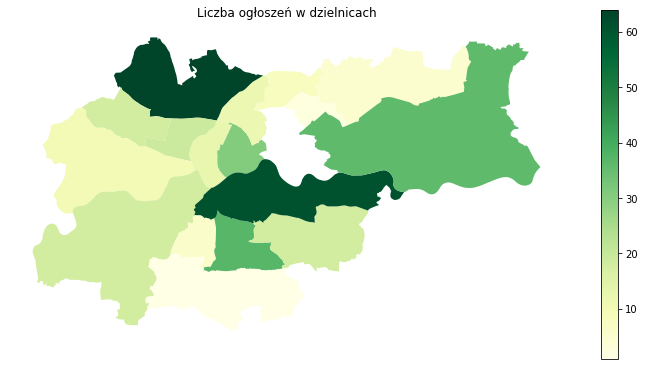

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_qnty.plot(column='qnty', cmap='YlGn', linewidth=1.5, ax=ax)

vmin, vmax = df_district_qnty['qnty'].min(), df_district_qnty['qnty'].max()
sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Liczba ogłoszeń w dzielnicach")
plt.tight_layout()
plt.show()

In [ ]:
print(df[df.price < 0].size)
print(df[df.pricePerMeter < 0].size)
print(df[df.rooms < 0].size)
print(df[df.surface < 0].size)

In [ ]:
df_district = df.groupby('district').mean()

df_district_mean = pd.merge(districts, df_district, left_on='nazwa', right_index=True)
df_district_mean.sort_values('price',ascending=False)

,objectid,mslink,mapid,id_dzielni,nr_dzielni,powierzchn,nazwa,nazwa_peln,opis,data_aktua,st_area(sh,st_length(,geometry,price,pricePerMeter,surface,rooms,rent,year
0,1.00,1.00,3013.00,1.00,I,5567646.00,STARE MIASTO,Dzielnica I Stare Miasto,UCHWALA NR XCIX/1495/14 RADY MIASTA KRAKOWA,2014-04-01,5567646.13,11730.27,"POLYGON ((566097.260 244329.716, 566097.477 24...",1112241.50,17472.30,58.43,2.25,170.80,1573.00
1,2.00,2.00,3013.00,2.00,II,5845232.00,GRZEGÓRZKI,Dzielnica II Grzegórzki,UCHWAŁA NR XCIX/1496/14 RADY MIASTA KRAKOWA,2014-04-01,5845232.08,11863.16,"POLYGON ((567784.500 244043.139, 567786.287 24...",1024611.85,14416.24,67.34,2.66,143.83,2018.32
6,7.00,7.00,3013.00,7.00,VII,28730964.00,ZWIERZYNIEC,Dzielnica VII Zwierzyniec,UCHWAŁA NR XCIX/1501/14 RADY MIASTA KRAKOWA,2014-04-01,28730964.28,27402.25,"POLYGON ((557355.217 244969.030, 557369.220 24...",1011724.75,17253.00,58.10,2.62,30.38,988.38
4,5.00,5.00,3013.00,5.00,V,5619039.00,KROWODRZA,Dzielnica V Krowodrza,UCHWAŁA NR XCIX/1499/14 RADY MIASTA KRAKOWA,2014-04-01,5619038.75,12351.02,"POLYGON ((563475.506 244986.213, 563476.971 24...",873069.48,12991.16,67.03,3.12,177.80,1277.44
7,8.00,8.00,3013.00,8.00,VIII,46188703.00,DĘBNIKI,Dzielnica VIII Dębniki,UCHWAŁA NR XCIX/1502/14 RADY MIASTA KRAKOWA,2014-04-01,46188702.80,40805.96,"POLYGON ((556746.136 238581.515, 556750.361 23...",773172.52,13592.04,55.75,2.60,297.24,1760.88
12,13.00,13.00,3013.00,13.00,XIII,25667082.00,PODGÓRZE,Dzielnica XIII Podgórze,UCHWAŁA NR XCIX/1507/14 RADY MIASTA KRAKOWA,2014-04-01,25667081.82,34696.02,"POLYGON ((566385.478 241086.274, 566390.281 24...",715532.91,11648.62,61.17,2.77,64.53,1064.75
5,6.00,6.00,3013.00,6.00,VI,9559587.00,BRONOWICE,Dzielnica VI Bronowice,UCHWAŁA NR XCIX/1500/14 RADY MIASTA KRAKOWA,2014-04-01,9559586.92,15472.48,"POLYGON ((559680.480 247139.293, 559681.829 24...",714187.55,13477.45,55.40,2.90,163.90,1205.25
2,3.00,3.00,3013.00,3.00,III,6437857.00,PRĄDNIK CZERWONY,Dzielnica III Prądnik Czerwony,UCHWAŁA NR XCIX/1497/14 RADY MIASTA KRAKOWA,2014-04-01,6437857.11,13926.66,"POLYGON ((567758.514 246401.517, 567774.358 24...",651915.31,11256.46,58.57,2.92,439.23,1527.92
15,16.00,16.00,3013.00,16.00,XVI,3699023.00,BIEŃCZYCE,Dzielnica XVI Bieńczyce,UCHWAŁA NR XCIX/1510/14 RADY MIASTA KRAKOWA,2014-04-01,3699023.40,11579.67,"POLYGON ((571760.606 247243.056, 571777.363 24...",622000.00,10649.00,58.62,3.00,600.00,1999.00
3,4.00,4.00,3013.00,4.00,IV,23418679.00,PRĄDNIK BIAŁY,Dzielnica IV Prądnik Biały,UCHWAŁA NR XCIX/1498/14 RADY MIASTA KRAKOWA,2014-04-01,23418679.08,29388.18,"POLYGON ((561609.805 249100.253, 561714.891 24...",619871.55,10847.55,57.87,2.93,112.74,1775.10


In [ ]:
df[df.district == 'ZWIERZYNIEC']

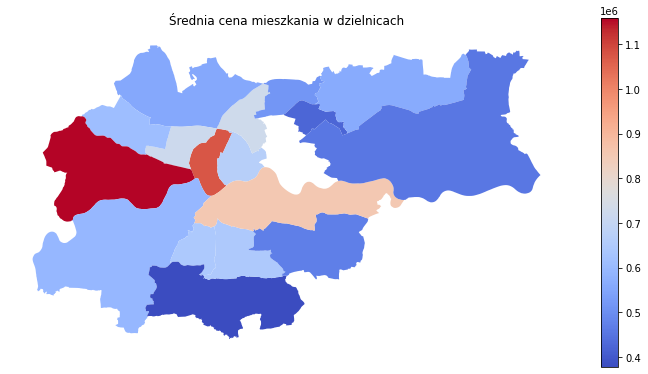

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_mean.plot(column='price', cmap='coolwarm', linewidth=1.5, ax=ax)

vmin, vmax = df_district_mean['price'].min(), df_district_mean['price'].max()
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Średnia cena mieszkania w dzielnicach")
plt.tight_layout()
plt.show()

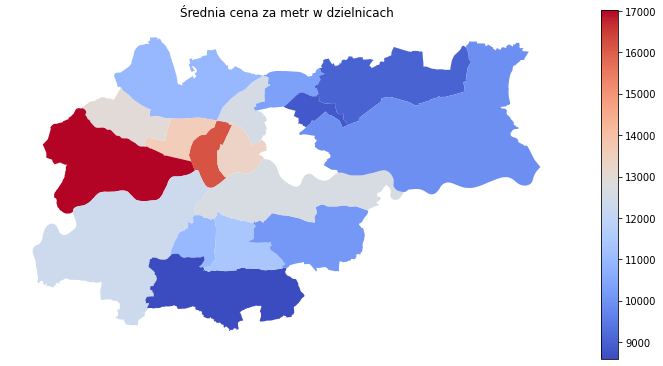

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_mean.plot(column='pricePerMeter', cmap='coolwarm', linewidth=1.5, ax=ax)

vmin, vmax = df_district_mean['pricePerMeter'].min(), df_district_mean['pricePerMeter'].max()
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Średnia cena za metr w dzielnicach")
plt.tight_layout()
plt.show()

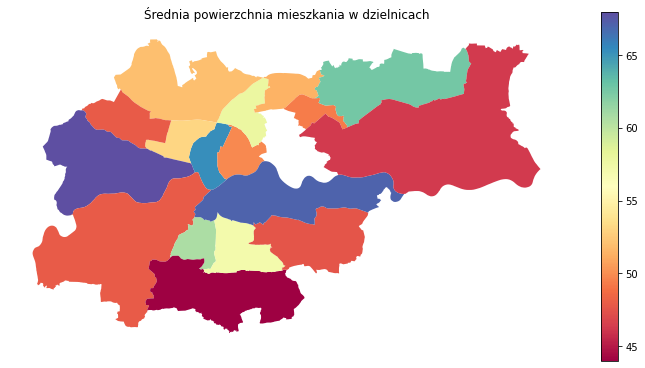

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
df_district_mean.plot(column='surface', cmap='Spectral', linewidth=1.5, ax=ax)

vmin, vmax = df_district_mean['surface'].min(), df_district_mean['surface'].max()
sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, shrink=0.5, ax=ax)

ax.grid(True)
ax.set_axis_off()
ax.set_title("Średnia powierzchnia mieszkania w dzielnicach")
plt.tight_layout()
plt.show()